In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

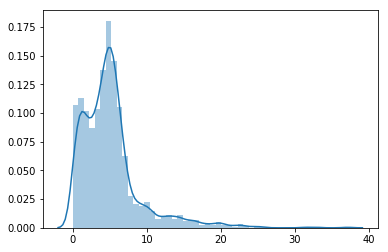

In [48]:
#Lets generate some exponentially increasing data
lambd = .2
mu = 5.
sig = 1.
Q = 500./1500.
d1 = np.random.exponential(scale = 1/lambd, size=1000)
d2 = np.random.normal(mu,sig**2,size=500)
d = np.append(d1,d2)
sns.distplot(d)
plt.show()

In [39]:
code = '''
data {
    int<lower = 0> N;
    real d[N];
}
parameters {
    real beta;
    real mu;
    real <lower=0.> sig;
    real <lower=0.,upper=1.> Q;
}
model {
    beta ~ normal(0.2,0.1);
    mu ~ normal(5.,1.);
    sig ~ normal(1.,0.1);
    Q ~ normal(0.5,.1);

    for (n in 1:N)
        target += log_mix(Q,
            normal_lpdf(d[n] | mu, sig),
            exponential_lpdf(d[n] | beta));
}

'''
sm = pystan.StanModel(model_code = code, model_name='exp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL exp_668f374be1005a8f13fbc698ac5b3299 NOW.


In [53]:
dat = {'N': len(d),
      'd': d}
fit = sm.sampling(data=dat, iter=5000, chains=1)


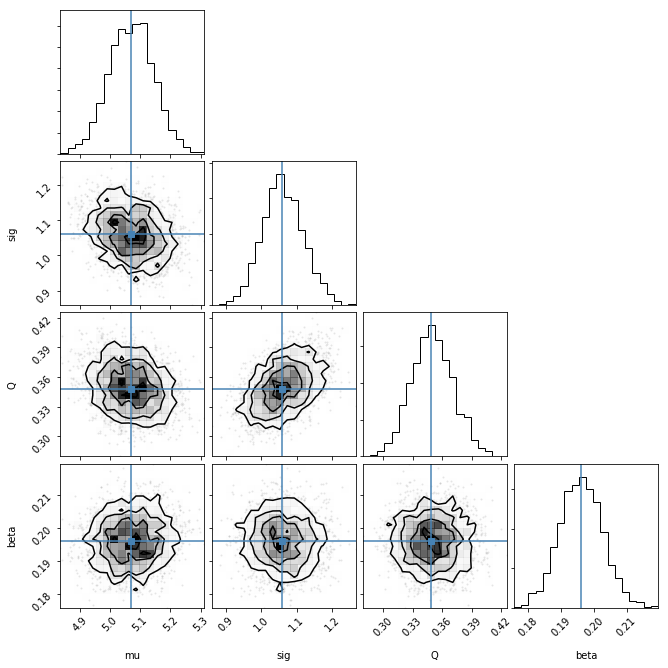

In [54]:
trace = fit.extract()
chain = np.array([trace['mu'],trace['sig'],trace['Q'],trace['beta']])
truths = [mu, sig, Q, lambd]
import corner
corner.corner(chain.T,truths=truths,labels=['mu','sig','Q','beta'])
plt.show()

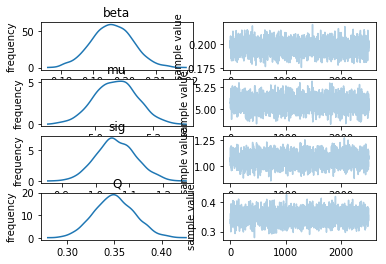

In [55]:
fit.plot()
plt.show()

5.071526077494512


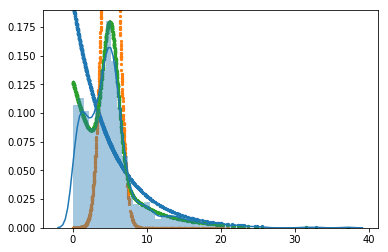

In [56]:
trace = fit.extract()
lambd = np.median(trace['beta'])
mu = np.median(trace['mu'])
sig = np.median(trace['sig'])
Q = np.median(trace['Q'])

bg = lambd*np.exp(-d*lambd)
fg = (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(d-mu)**2/(2*sig**2))
pp = Q*fg + (1-Q)*bg

sns.distplot(d)
plt.scatter(d, bg,s=5)
plt.scatter(d, fg,s=5)
plt.scatter(d, pp,s=5)
print(mu)

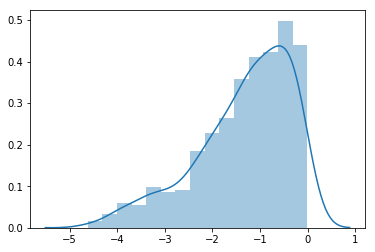

In [9]:
'''Now lets make a gaussian'''
true_m = 1.
true_sig = 2.
d = np.random.normal(true_m,true_sig,size=2000)
d = d[d<0.]
sns.distplot(d)
plt.show()

In [10]:
code = '''
functions {
    real logposexp(real x, real hi, real lo, real lambd) {
        real A;
        A = log(lambd*(exp(lambd*hi)-exp(lambd*lo))^-1);
        return lambd*x + A;
        }
}
data {
    int<lower = 0> N;
    real d[N];
}
parameters {
    real lambd;
}
model {
    lambd ~ normal(0, 1e6);
    for (n in 1:N)
        target += logposexp(d[n], max(d), min(d), lambd);
}

'''
sm = pystan.StanModel(model_code = code, model_name='offgauss')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL offgauss_4220f1ee532b7127dfcfae634a1f2de9 NOW.


In [11]:
dat = {'N': len(d),
      'd': d}
fit = sm.sampling(data=dat, iter=1000, chains=1)

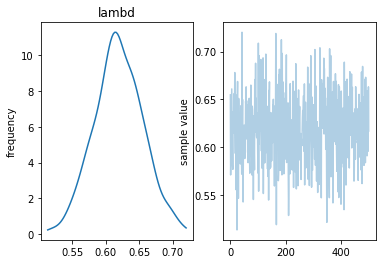

In [12]:
fit.plot()
plt.show()

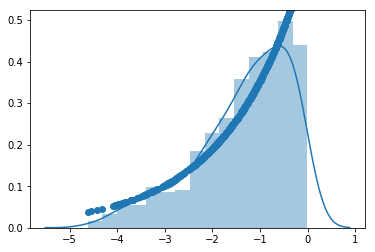

In [14]:
trace = fit.extract()
lambd = np.median(trace['lambd'])
sns.distplot(d)
p = (lambd*(np.exp(lambd*d.max()) - np.exp(lambd*d.min()))**-1)\
                                               *np.exp(lambd*d)
plt.scatter(d,p)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'#Gc', u'logAge', u'[M/H]', u'm_ini', u'logL', u'logTe', u'logg',
       u'm-M0', u'Av', u'm2/m1', u'mbol', u'U', u'B', u'V', u'R', u'I', u'J',
       u'H', u'K', u'Mact'],
      dtype='object')


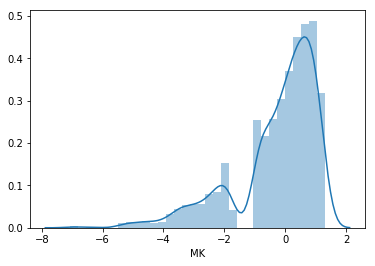

In [15]:
import pandas as pd
sfile = 'file2.txt'
df = pd.read_csv(sfile, sep='\s+')
df.head(5)
print(df.columns)
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V\
#Make some cuts
df = df.loc[np.abs(df.BV - 0.9) < 0.6]
df = df.loc[df.K > 8.0]
df = df.loc[df.logg < 3.5]
#Calculate absolute magnitude (no extinction)
df['MK'] = df.K - 5.0 * np.log10(df.dist) + 5.0
df1 = df[df.MK < -1.8]
df2 = df[df.MK > -1.]
dfn = pd.concat([df1,df2])
#Plot absolute magnitude in K
sns.distplot(dfn.MK)


In [16]:
dat = {'N': len(df.MK),
      'd': df.MK}
fit = sm.sampling(data=dat, iter=1000, chains=1)

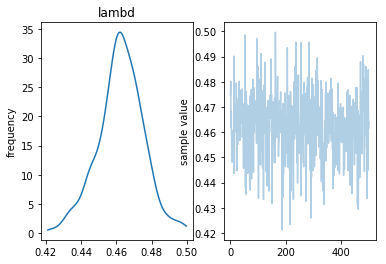

In [17]:
fit.plot()
plt.show()

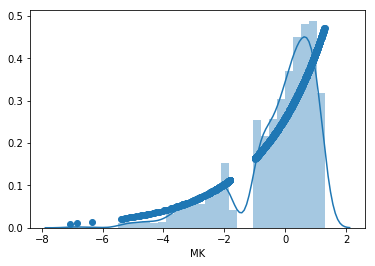

In [18]:
trace = fit.extract()
lambd = np.median(trace['lambd'])
sns.distplot(dfn.MK)
p = (lambd*(np.exp(lambd*dfn.MK.max()) - np.exp(lambd*dfn.MK.min()))**-1)\
                                               *np.exp(lambd*dfn.MK)
plt.scatter(dfn.MK,p)

In [19]:
print(lambd)

0.4625217579798588


In [20]:
len(dfn)

1434

In [21]:
len(df)

2192

In [24]:
1.-(1434./2192.)

0.34580291970802923

In [25]:
np.median(df)

10.584000000000001

In [28]:
np.median(df.MK[df.MK<-1.45])


-1.681000000000001